In [1]:
root_path = '../input/bitcoin-historic-prices-from-oct2015-to-oct2021/btc_ohlc_Oct_2015_to_Oct_2021.csv'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [3]:
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [4]:
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [5]:
btc_input_df.shape

(3113276, 6)

In [6]:
btc_input_df.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849557e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [7]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


In [8]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [9]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


In [10]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='time'>

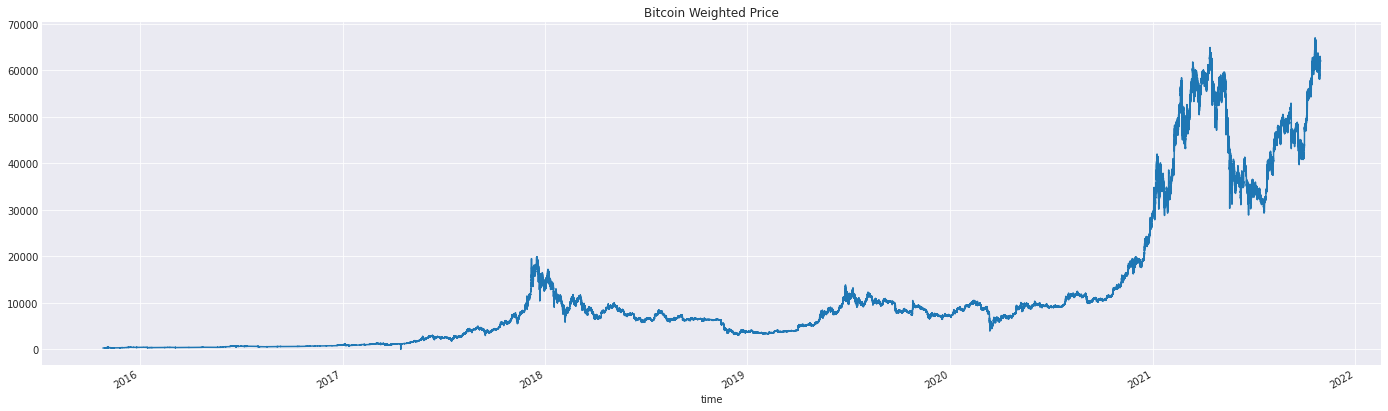

In [11]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

# **Lag Plot**

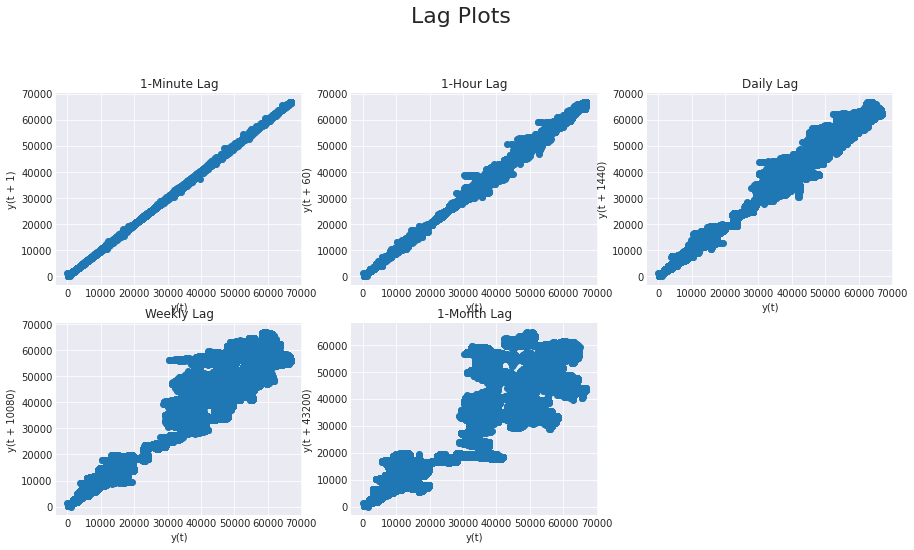

In [12]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [13]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [14]:
btc_closing_price_groupby_date.head()

date
2015-10-27    292.887484
2015-10-28    301.991834
2015-10-29    310.537530
2015-10-30    326.665808
2015-10-31    323.877132
Name: close, dtype: float64

In [15]:
print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

Length of btc_closing_price_groupby_date : 2196


In [16]:
prediction_days = 60
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [17]:
df_test.shape

(60, 1)

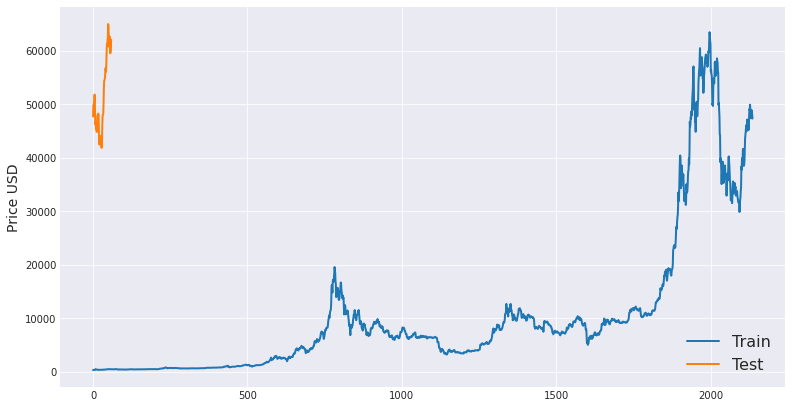

In [18]:
chosen_col = 'Close'
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [19]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [20]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2131, 5)
trainY:  (2131,)
testX:  (55, 5)
testY (55,)


In [21]:
print("trainX: ", trainX)
print("---")
print("trainY: ", trainY)

trainX:  [[0.00000000e+00 1.44159882e-04 2.79473948e-04 5.34851927e-04
  4.90695552e-04]
 [1.44159882e-04 2.79473948e-04 5.34851927e-04 4.90695552e-04
  4.21819458e-04]
 [2.79473948e-04 5.34851927e-04 4.90695552e-04 4.21819458e-04
  7.33745838e-04]
 ...
 [7.69797191e-01 7.59576884e-01 7.45106076e-01 7.51304260e-01
  7.69632673e-01]
 [7.59576884e-01 7.45106076e-01 7.51304260e-01 7.69632673e-01
  7.65970936e-01]
 [7.45106076e-01 7.51304260e-01 7.69632673e-01 7.65970936e-01
  7.56740572e-01]]
---
trainY:  [4.21819458e-04 7.33745838e-04 1.48661180e-03 ... 7.65970936e-01
 7.56740572e-01 7.44388678e-01]


In [22]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))
print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2131, 5, 1)
Shape of testX:  (55, 5, 1)


In [23]:
print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [24]:
regressor = Sequential()
regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences = True,input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 64, activation = 'relu',input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

2022-06-25 16:42:37.963399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 16:42:37.967693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 16:42:37.968375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 16:42:37.970121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 256)            264192    
_________________________________________________________________
dropout (Dropout)            (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/600


2022-06-25 16:42:41.277537: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


67/67 [==============================] - 6s 37ms/step - loss: 0.0167 - val_loss: 0.0797

Epoch 00001: val_loss improved from inf to 0.07968, saving model to my_best_model.hdf5
Epoch 2/600
67/67 [==============================] - 3s 38ms/step - loss: 0.0283 - val_loss: 0.0437

Epoch 00002: val_loss improved from 0.07968 to 0.04366, saving model to my_best_model.hdf5
Epoch 3/600
67/67 [==============================] - 2s 31ms/step - loss: 0.0207 - val_loss: 0.0497

Epoch 00003: val_loss did not improve from 0.04366
Epoch 4/600
67/67 [==============================] - 2s 30ms/step - loss: 0.0117 - val_loss: 0.0185

Epoch 00004: val_loss improved from 0.04366 to 0.01847, saving model to my_best_model.hdf5
Epoch 5/600
67/67 [==============================] - 2s 31ms/step - loss: 0.0045 - val_loss: 0.0213

Epoch 00005: val_loss did not improve from 0.01847
Epoch 6/600
67/67 [==============================] - 2s 30ms/step - loss: 0.0030 - val_loss: 0.0229

Epoch 00006: val_loss did not impro

In [26]:
from tensorflow.keras.models import load_model
model_from_saved_checkpoint = load_model(checkpoint_path)

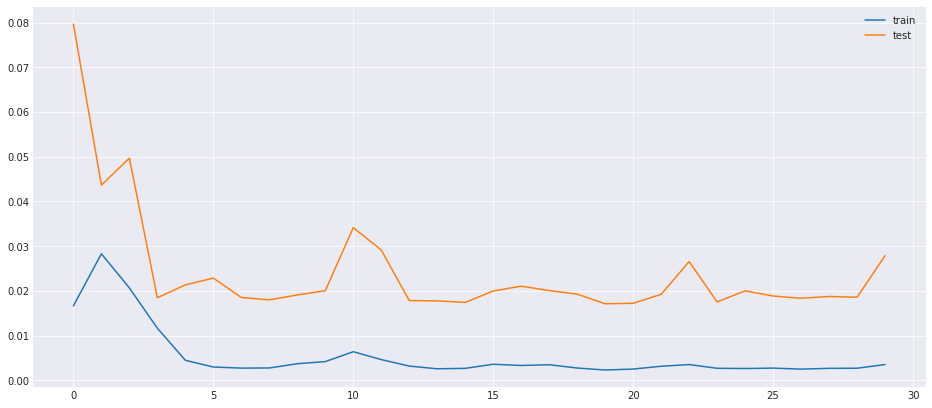

In [27]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

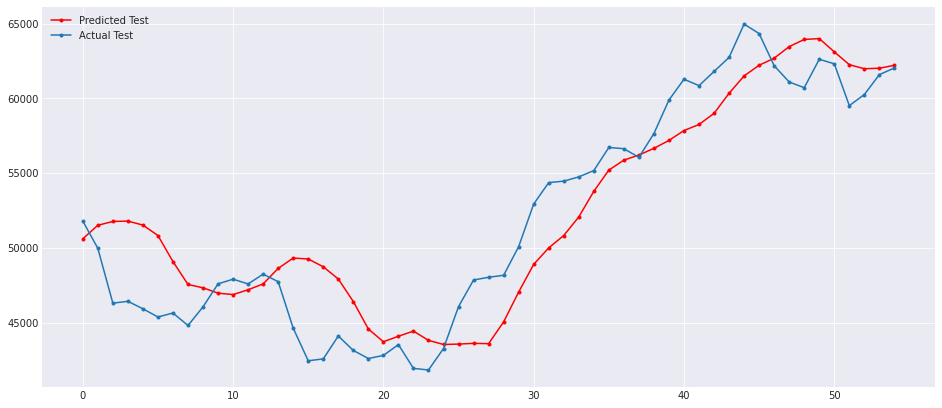

In [29]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

In [30]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

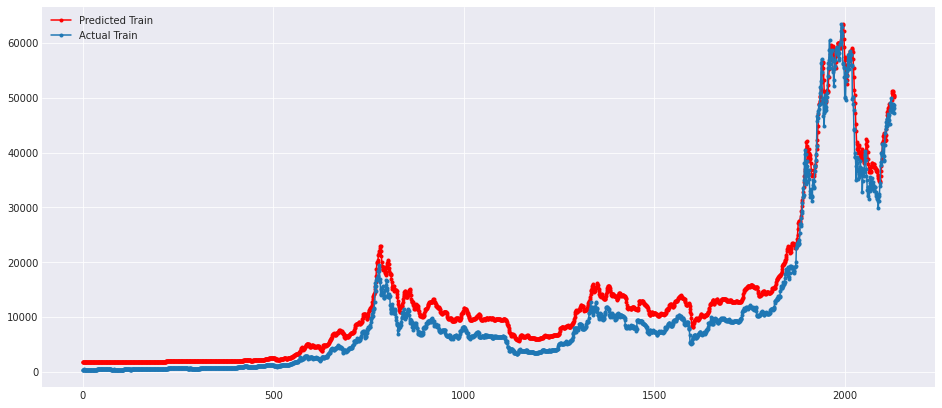

In [31]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.legend()
plt.show()